# Evaluate Integrator Accuracy

## RK4

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt

from jorbit.utils.system_state import SystemState
from jorbit.integrators import IntegratorState
from jorbit.accelerations import newtonian_gravity
from jorbit.integrators import rk4_evolve

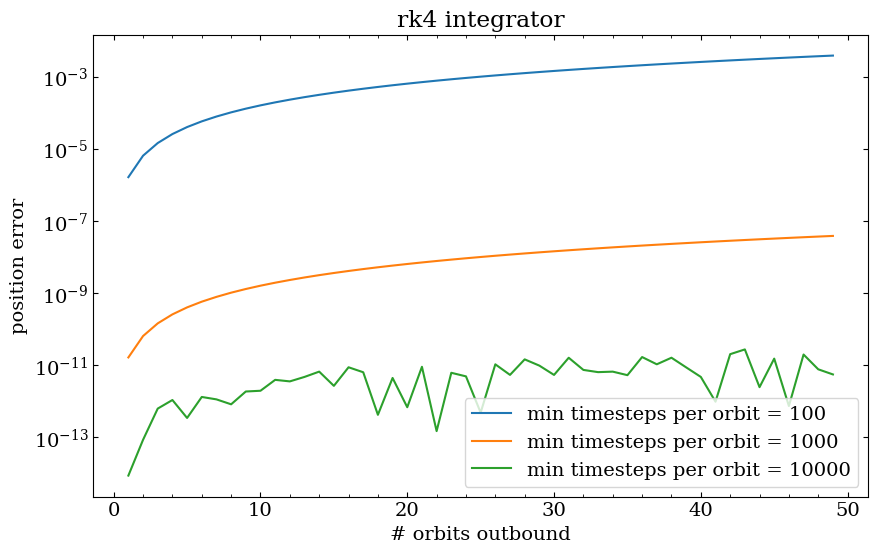

In [2]:
initial_system_state = SystemState(
    positions=jnp.array([[0.0, 0, 0], [1.0, 0, 0]]),
    velocities=jnp.array([[0.0, 0, 0], [0.0, 1.0, 0]]),
    gms=jnp.array([1.0, 0.0]),
    time=0.0,
)

fig, ax = plt.subplots(figsize=(10, 6))
n_orbits_outbound = jnp.arange(1, 50, 1)

for min_timesteps_per_orbit in [100, 1_000, 10_000]:
    known_period = 2 * jnp.pi
    dt_limit = known_period / min_timesteps_per_orbit

    initial_integrator_state = IntegratorState(dt=dt_limit, meta={"dt_limit": dt_limit})

    acc_func = jax.tree_util.Partial(newtonian_gravity)

    tracer_position_errors = []
    for n_orbits in n_orbits_outbound:

        t_out = 2 * jnp.pi * n_orbits
        new_system_state, new_integrator_state = rk4_evolve(
            initial_system_state,
            acc_func,
            t_out,
            initial_integrator_state,
            int(t_out / initial_integrator_state.dt) + 1,
        )

        new_integrator_state.dt = dt_limit
        new_system_state, new_integrator_state = rk4_evolve(
            new_system_state,
            acc_func,
            0.0,
            new_integrator_state,
            int(t_out / initial_integrator_state.dt) + 1,
        )
        err = jnp.linalg.norm(new_system_state.positions[1] - jnp.array([1.0, 0, 0]))
        tracer_position_errors.append(err)

    ax.plot(
        n_orbits_outbound,
        tracer_position_errors,
        label=f"min timesteps per orbit = {min_timesteps_per_orbit}",
    )

ax.set(
    xlabel="# orbits outbound",
    ylabel="position error",
    yscale="log",
    title="rk4 integrator",
)
ax.legend()

## Leapfrog

In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt

from jorbit.utils.system_state import SystemState
from jorbit.integrators import IntegratorState
from jorbit.accelerations import newtonian_gravity

from jorbit.integrators import yoshida_step
from jorbit.data.constants import Y4_C, Y4_D

In [4]:
initial_system_state = SystemState(
    positions=jnp.array([[0.0, 0, 0], [1.0, 0, 0]]),
    velocities=jnp.array([[0.0, 0, 0], [0.0, 1.0, 0]]),
    gms=jnp.array([1.0, 0.0]),
    time=0.0,
)

dt_limit = 0.01
initial_integrator_state = IntegratorState(dt=dt_limit,
    meta={"dt_limit": dt_limit,
    "leapfrog_coeffs" : {"C" : Y4_C, "D" : Y4_D}})
acc_func = jax.tree_util.Partial(newtonian_gravity)

yoshida_step(initial_system_state, acc_func, initial_integrator_state)[0].positions

Array([[0.        , 0.        , 0.        ],
       [0.99995   , 0.00999983, 0.        ]], dtype=float64)